In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("./drive/MyDrive/VGTU/Deep_Learning_Systems/Lab3_pics")
!pwd

/content/drive/MyDrive/VGTU/Deep_Learning_Systems/Lab3_pics


##Intro
"Deep dream" is an image-filtering technique which consists of taking an image
classification model, and running gradient ascent over an input image to
try to maximize the activations of specific layers (and sometimes, specific units in
specific layers) for this input. It produces hallucination-like visuals.


Process:

- Load the original image.
- Define a number of processing scales ("octaves"),
from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.
To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.

**Importing libraries**

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16, vgg19

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Image, display

setting up our base image

106496/90880 [===================================] - 0s 0us/step


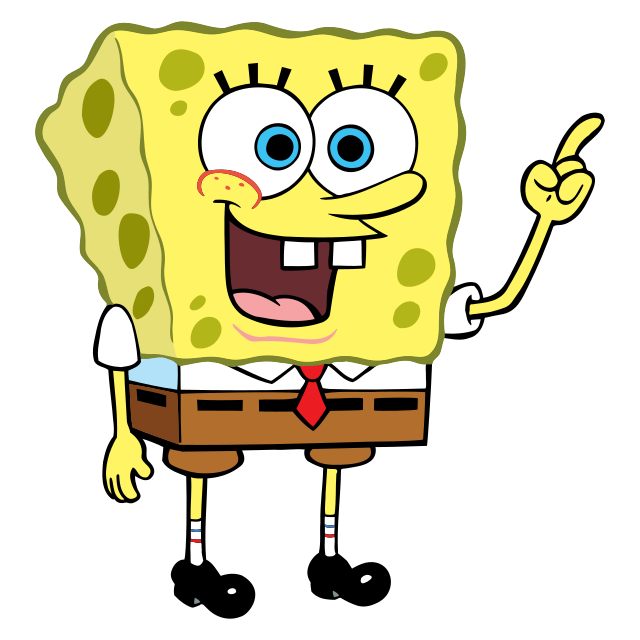

In [4]:
# base_image_path = keras.utils.get_file("shibu.jpg", "https://www.akc.org/wp-content/uploads/2017/11/Shiba-Inu-standing-in-profile-outdoors.jpg")
# result_prefix = "shibu"
# base_image_path = keras.utils.get_file("train.jpg", "https://img.fonwall.ru/o/6/parovoz-truba-dyim-vagonyi.jpg")
# result_prefix = "train"
base_image_path = keras.utils.get_file("spongebob.jpg", "https://upload.wikimedia.org/wikipedia/en/thumb/3/3b/SpongeBob_SquarePants_character.svg/640px-SpongeBob_SquarePants_character.svg.png")
result_prefix = "spongebob"
display(Image(base_image_path))

We will use vgg16/vgg19 model trained on imagenet dataset.

In [5]:
# Try experimenting with a more interesting models
model = vgg16.VGG16(weights="imagenet", include_top=False)
# model = vgg19.VGG19(weights="imagenet", include_top=False)
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

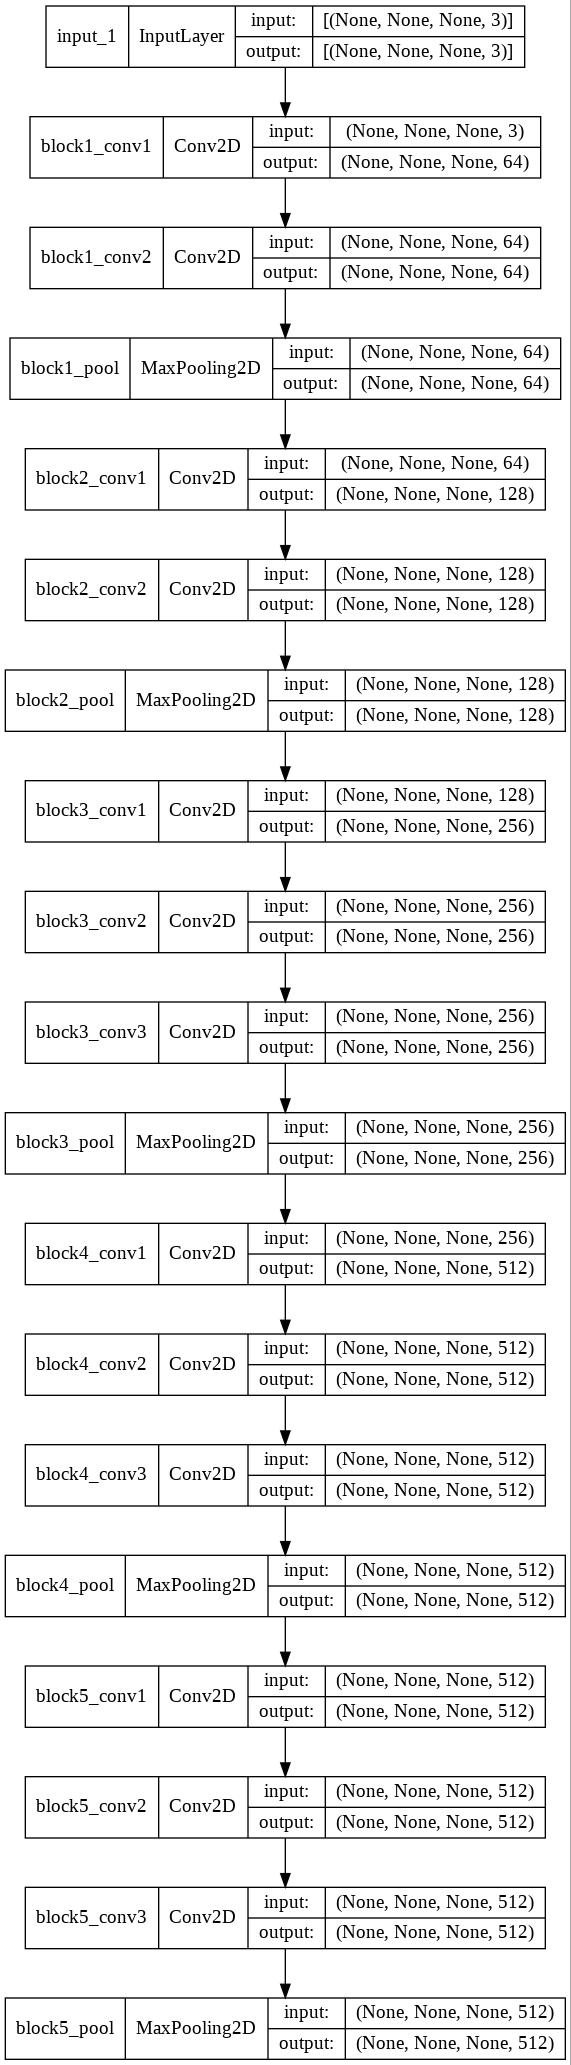

In [6]:
keras.utils.plot_model(model, to_file="vgg19_arch.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

Setting up the layers which activations we want to maximize

In [7]:
ii=0

In [57]:
ii+=1
# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
layer_settings = {
# vgg16
# "block2_conv2": 1.0
# "block3_conv3": 1.0
# "block4_conv3": 1.0
"block5_conv3": 1.0         
# vgg19
# "block2_conv2": 1.0
# "block3_conv4": 1.0
# "block4_conv4": 1.0
# "block5_conv4": 1.0 
}

# v1
# step = 0.01  # Gradient ascent step size
# num_octave = 7  # Number of scales at which to run gradient ascent
# octave_scale = 1.15  # Size ratio between scales
# iterations = 30  # Number of ascent steps per scale
# max_loss = 55.0

# v2
step = 0.01  # Gradient ascent step size
num_octave = 4  # Number of scales at which to run gradient ascent
octave_scale = 1.3  # Size ratio between scales
iterations = 30  # Number of ascent steps per scale
max_loss = 55.0

Let's set up some image preprocessing/deprocessing utilities:

In [58]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Preprocess image
    img = img / 127.5 - 1.0
    return img


def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Undo image preprocessing
    x += 1.0
    x *= 127.5
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Compute the Deep Dream loss

First, build a feature extraction model to retrieve the activations of our target layers
given an input image.

In [59]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

print(outputs_dict)

# Set up a model that returns the activation values for every target layer
# (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

{'block5_conv3': <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv3')>}


The actual loss computation is very simple:

In [60]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

## Set up the gradient ascent loop for one octave

In [61]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

## Run the training loop, iterating over different octaves

In [62]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

temp = f'_subset_{ii}'
keras.preprocessing.image.save_img(result_prefix + temp + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (291, 291)
... Loss value at step 0: 0.16
... Loss value at step 1: 0.19
... Loss value at step 2: 0.23
... Loss value at step 3: 0.28
... Loss value at step 4: 0.33
... Loss value at step 5: 0.39
... Loss value at step 6: 0.46
... Loss value at step 7: 0.53
... Loss value at step 8: 0.61
... Loss value at step 9: 0.70
... Loss value at step 10: 0.81
... Loss value at step 11: 0.93
... Loss value at step 12: 1.04
... Loss value at step 13: 1.18
... Loss value at step 14: 1.32
... Loss value at step 15: 1.48
... Loss value at step 16: 1.62
... Loss value at step 17: 1.82
... Loss value at step 18: 2.00
... Loss value at step 19: 2.21
... Loss value at step 20: 2.38
... Loss value at step 21: 2.55
... Loss value at step 22: 2.77
... Loss value at step 23: 3.00
... Loss value at step 24: 3.24
... Loss value at step 25: 3.56
... Loss value at step 26: 3.79
... Loss value at step 27: 4.05
... Loss value at step 28: 4.31
... Loss value at step 29: 4.63
Processi

Display the result.

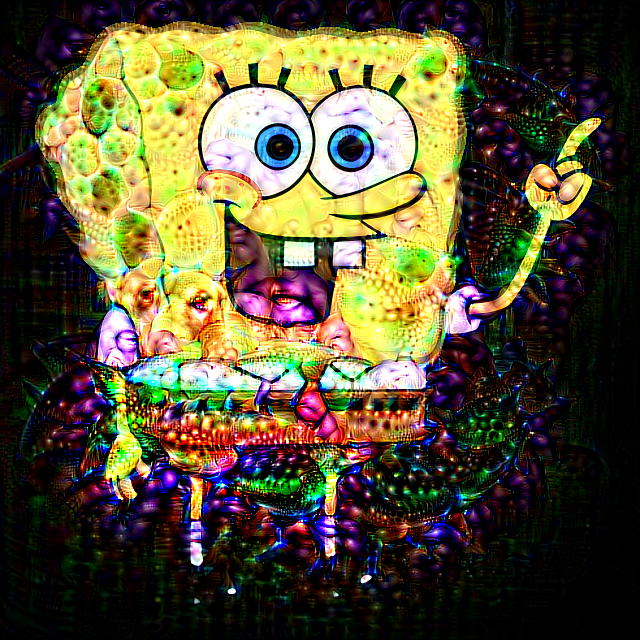

In [63]:
display(Image(result_prefix + temp + ".png"))